<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "2B"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/2B/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


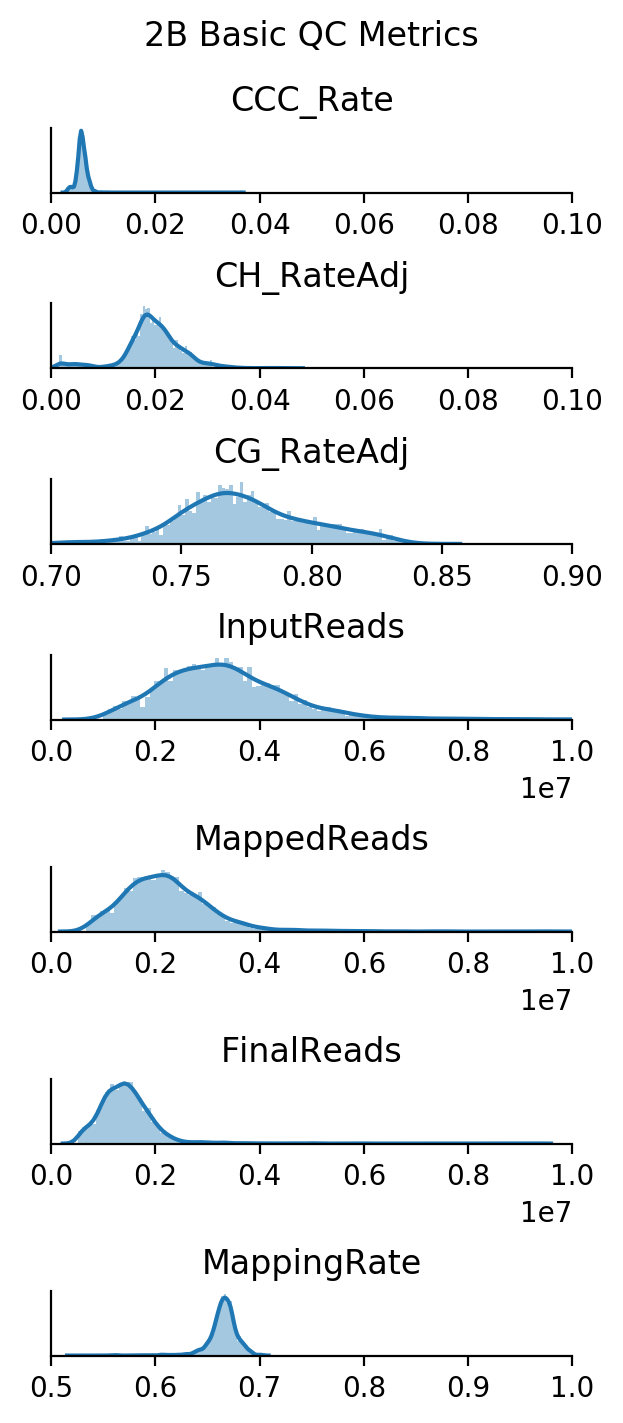

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

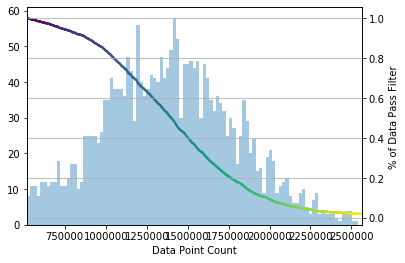

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2381/2381 (100.0%)
CG_RateAdj passed 2381/2381 (100.0%)
CH_RateAdj passed 2381/2381 (100.0%)
FinalReads passed 2381/2381 (100.0%)
MappingRate passed 2381/2381 (100.0%)
Overall passed 2381/2381 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180305 1011
180306 1370


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 297 77.3%
ad002 294 76.6%
ad004 299 77.9%
ad006 307 79.9%
ad007 297 77.3%
ad008 289 75.3%
ad010 296 77.1%
ad012 302 78.6%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
2B_M_0,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180305_2B...,0.00555,0.76402,0.76270,0.02340,0.01795,679179.0,1561022,957644.0,2B,...,1.295681,-12.465449,-0.163093,42.299033,IT-L23 Cux1,-1.817732,4.899231,-9.257660,-10.619155,True
2B_M_1,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180305_2B...,0.00615,0.77374,0.77234,0.02453,0.01849,524705.0,1236472,748902.0,2B,...,13.598912,-5.290937,0.518607,-12.236035,IT-L6 Man1c1,-9.902554,-4.831508,17.890840,-1.539236,True
2B_M_10,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180305_2B...,0.00707,0.78262,0.78107,0.03185,0.02496,1646521.0,3885176,2615205.0,2B,...,10.465723,9.793705,48.358590,24.715440,PT-L5 Tenm2,-11.697989,4.912844,4.922336,3.176683,True
2B_M_100,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180305_2B...,0.00600,0.78428,0.78298,0.02526,0.01938,1341475.0,3148344,2092465.0,2B,...,20.960342,8.964107,-38.667010,-29.378422,CT-L6 Il1rap,-5.592174,-15.500788,18.668048,-1.097660,True
2B_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180305_2B...,0.00650,0.82850,0.82738,0.02905,0.02270,1102864.0,2428330,1594946.0,2B,...,26.176664,1.602996,-3.945685,-37.578810,NP-L6 Olfml2b,3.963665,-1.880718,6.768713,0.033149,True
2B_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180305_2B...,0.00677,0.76626,0.76467,0.03124,0.02464,856878.0,1882526,1238662.0,2B,...,8.479416,10.886184,59.296550,18.173856,PT-L5 Kcnh1,-12.527719,12.211041,-6.618183,-19.243080,True
2B_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180306_2B...,0.00583,0.74964,0.74817,0.02381,0.01809,884916.0,1993042,1279260.0,2B,...,2.390993,-11.876462,-5.758980,37.477486,IT-L23 Cux1,-3.189557,4.133206,-17.310435,-6.221864,True
2B_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180306_2B...,0.00645,0.77484,0.77338,0.02647,0.02015,715037.0,1628782,1041695.0,2B,...,14.385250,-8.471364,20.390994,-4.703698,IT-L6 Fstl4,-6.977516,0.927140,7.789520,33.366169,True
2B_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180305_2B...,0.00667,0.77251,0.77098,0.03243,0.02593,1521756.0,3550686,2386396.0,2B,...,10.402149,10.483121,47.851834,25.469814,PT-L5 Plcb4,-10.192711,6.762346,8.459073,-10.894647,True
2B_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/2B/CEMBA180305_2B...,0.00789,0.80890,0.80738,0.03924,0.03160,1061220.0,2419658,1674019.0,2B,...,-29.020466,1.806031,-43.748722,-19.992420,MGE-Pvalb Ptprk,3.483611,-14.329891,-29.196889,1.146204,True
